In [11]:
#importing data
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib.pylab import mean

#Cleaning CDI Data
CDI_raw = pd.read_csv("/Users/abbyhultquist/Documents/CDI outputs/CDI_raw.csv")
CDI = CDI_raw.copy()

print("Initial CDI shape:", CDI.shape)
CDI = CDI.sort_values(['child_id', 'session_num'])
print("# of children", CDI['child_id'].nunique())


Initial CDI shape: (1167, 699)
# of children 122


In [12]:
#creating a list of ALL words 
word_cols = CDI.columns[19:].tolist()
metadata_cols = CDI.columns[:19].tolist()
print("total # words considered:", len(word_cols))


total # words considered: 680


In [13]:
#converting known words to binary (1 if known, 0 if not)

CDI[word_cols] = CDI[word_cols].apply(pd.to_numeric, errors='coerce').fillna(0)
CDI[word_cols] = (CDI[word_cols] >= 1).astype(int)

# Defragment before adding new column
CDI = CDI.copy()

# Recompute vocab counts with binary values - axis = 1 means we are summing across columns (i.e., summing the number of known words for each child)
CDI['vocab_size'] = CDI[word_cols].sum(axis=1)

print("len(word_cols) =", len(word_cols))
print("max vocab_size =", CDI['vocab_size'].max())

len(word_cols) = 680
max vocab_size = 680


In [14]:
# Once a word is learned, it stays learned 


CDI = CDI.sort_values(['child_id', 'session_num'])

# Ensure word columns are numeric/binary 
CDI[word_cols] = CDI[word_cols].apply(pd.to_numeric, errors='coerce').fillna(0) 
CDI[word_cols] = (CDI[word_cols] > 0).astype(int)       # Convert to binary (1 if known, 0 if not) using boolean indexing

# Snapshot vocab before cumulative maximum function
pre_vocab = CDI[word_cols].sum(axis=1)
pre_desc = pre_vocab.mean()

# Cumulative knowledge within each child
CDI[word_cols] = CDI.groupby('child_id', sort=False)[word_cols].cummax() 

# Update words_spoken and vocab_size to reflect cumulative knowledge
CDI['words_spoken'] = CDI[word_cols].sum(axis=1)
CDI['vocab_size'] = CDI['words_spoken']

post_desc = CDI['vocab_size'].mean()

print("Mean Before cumulative max :\n", pre_desc)
print("\nAfter cummax vocab_size summary:\n", post_desc)

Mean Before cumulative max :
 307.4661525278492

After cummax vocab_size summary:
 315.87232219365893


In [15]:
#categorize talker types
import numpy as np

#adjustable parameters for talker categorization
early_session = 1                               #starting point for early sessions
late_session = 9                                #session to compare against for late sessions
num_sessions_ave = 2                            #number of sessions to average for early sessions (e.g., 2 means average sessions 1 and 2)
percentile_threshold = 20

CDI = CDI.sort_values(['child_id', 'session_num'])
talker_dict = {}
for child_id, group in CDI.groupby('child_id'):
#between early sessions
    early = group[group['session_num'].between(early_session, early_session + num_sessions_ave - 1)]
    early_vals = early['percentile']
    early_vals = early_vals[early_vals != 0]
    early_mean = early_vals.mean()
#between late sessions
    late = group[group['session_num'].between(late_session, late_session + num_sessions_ave - 1)]
    late_vals = late['percentile']
    late_vals = late_vals[late_vals != 0]
    late_mean = late_vals.mean()

    # Skip if no usable data
    if np.isnan(early_mean) or np.isnan(late_mean): #removing kids that dont have data in early or late
        continue

    lt_early = early_mean < percentile_threshold 
    lt_late = late_mean < percentile_threshold

    if lt_early and lt_late: #if both early and late are below threshold, they are PLT
        talker_type = 'PLT'
    elif lt_early and not lt_late: #if early is below threshold but late is not, they are LB
        talker_type = 'LB'
    elif not lt_early and not lt_late: #if both early and late are above threshold, they are TT
        talker_type = 'TT'
    else: #if early is above threshold but late is below, they are a Faller
        talker_type = 'Faller'

    talker_dict[child_id] = talker_type

# Count from dictionary
counts = pd.Series(talker_dict).value_counts()
print(counts)
print("Total classified:", counts.sum())

CDI['Talker_Type'] = CDI['child_id'].map(talker_dict)
print("Children classified:", len(talker_dict))
print("Unique children in data:", CDI['child_id'].nunique())

# Reorder columns: vocab_size and Talker_Type before word columns
ordered_cols = metadata_cols + ['vocab_size', 'Talker_Type'] + word_cols
ordered_cols = [c for c in ordered_cols if c in CDI.columns]
ordered_cols = list(dict.fromkeys(ordered_cols))
CDI = CDI[ordered_cols]


TT        58
LB        25
PLT        8
Faller     2
Name: count, dtype: int64
Total classified: 93
Children classified: 93
Unique children in data: 122


In [16]:
# Export CSV with talker labels
output_path = f"/Users/abbyhultquist/Documents/First Year Project/long_categorization_{late_session}.csv"

# Ensure Talker_Type is included
if 'Talker_Type' not in CDI.columns:
    raise ValueError("Talker_Type not found. Run the categorization cell first.")

CDI.to_csv(output_path, index=False)
print(f"Saved: {output_path}")

Saved: /Users/abbyhultquist/Documents/First Year Project/long_categorization_9.csv


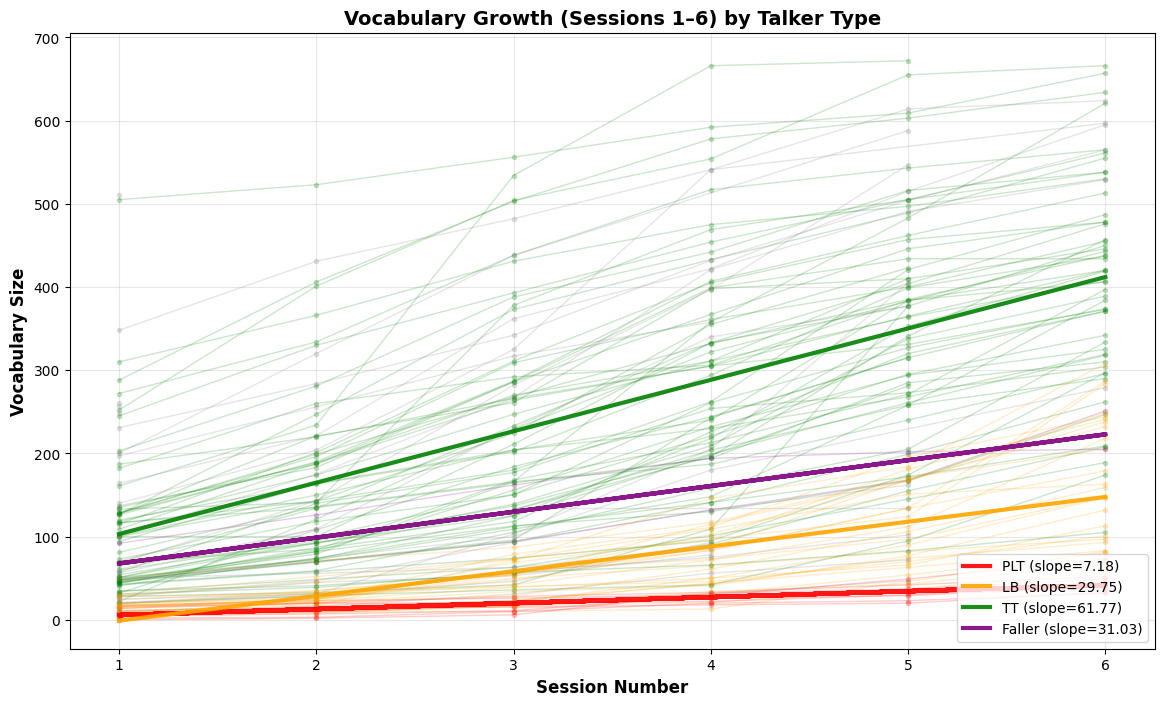

In [17]:
# Plot vocab_size growth (sessions 1–6) by talker type (classified via averaged percentiles)
import matplotlib.pyplot as plt
from scipy import stats as sp_stats
import numpy as np

color_map = {'PLT': 'red', 'LB': 'orange', 'TT': 'green', 'Faller': 'purple'}

# Restrict to sessions 1–6 (no averaging in the plot)
CDI_plot = CDI[CDI['session_num'].between(1, 6)].copy()

fig, ax = plt.subplots(figsize=(14, 8))

# Plot individual trajectories
for child_id, group in CDI_plot.groupby('child_id'):
    group = group.sort_values('session_num')
    talker_type = group['Talker_Type'].iloc[0]
    color = color_map.get(talker_type, 'gray')
    
    ax.plot(group['session_num'], group['vocab_size'],
            color=color, alpha=0.2, linewidth=1, marker='o', markersize=3)

# Add trend lines for each talker type
for talker_type in ['PLT', 'LB', 'TT', 'Faller']:
    group_data = CDI_plot[CDI_plot['Talker_Type'] == talker_type].copy()
    if len(group_data) == 0:
        continue
    
    # Prepare data for trendline
    x = group_data['session_num'].values
    y = group_data['vocab_size'].values
    
    # Calculate linear regression
    slope, intercept, r_value, p_value, std_err = sp_stats.linregress(x, y)
    line = slope * x + intercept
    
    # Plot trendline
    color = color_map.get(talker_type, 'gray')
    ax.plot(x, line, color=color, linewidth=3, alpha=0.9,
            label=f'{talker_type} (slope={slope:.2f})')
    
ax.set_xlabel('Session Number', fontsize=12, fontweight='bold')
ax.set_ylabel('Vocabulary Size', fontsize=12, fontweight='bold')
ax.set_title('Vocabulary Growth (Sessions 1–6) by Talker Type', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='lower right', fontsize=10)


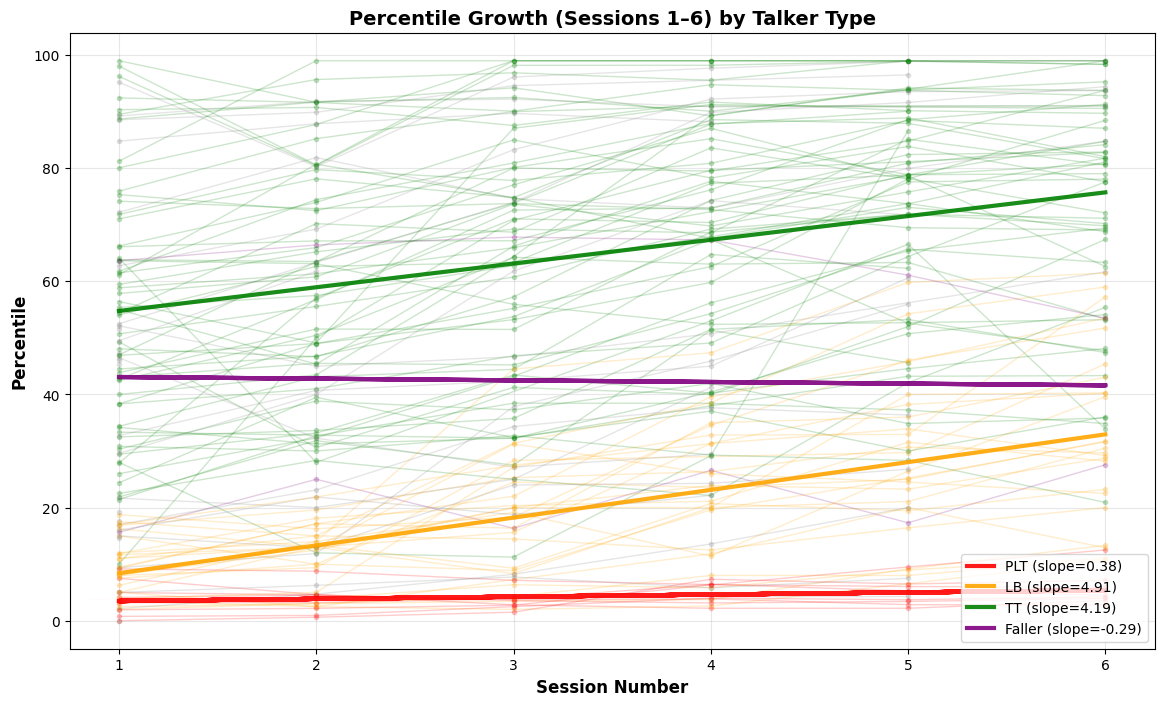

In [18]:
# Plot percentile growth (sessions 1–6) by talker type (classified via averaged percentiles)
import matplotlib.pyplot as plt
from scipy import stats as sp_stats
import numpy as np

color_map = {'PLT': 'red', 'LB': 'orange', 'TT': 'green', 'Faller': 'purple'}

# Restrict to sessions 1–6 (no averaging in the plot)
CDI_plot = CDI[CDI['session_num'].between(1, 6)].copy()

fig, ax = plt.subplots(figsize=(14, 8))

# Plot individual trajectories
for child_id, group in CDI_plot.groupby('child_id'):
    group = group.sort_values('session_num')
    talker_type = group['Talker_Type'].iloc[0]
    color = color_map.get(talker_type, 'gray')
    
    ax.plot(group['session_num'], group['percentile'],
            color=color, alpha=0.2, linewidth=1, marker='o', markersize=3)

# Add trend lines for each talker type
for talker_type in ['PLT', 'LB', 'TT', 'Faller']:
    group_data = CDI_plot[CDI_plot['Talker_Type'] == talker_type].copy()
    if len(group_data) == 0:
        continue
    
    # Prepare data for trendline
    x = group_data['session_num'].values
    y = group_data['percentile'].values
    
    # Calculate linear regression
    slope, intercept, r_value, p_value, std_err = sp_stats.linregress(x, y)
    line = slope * x + intercept
    
    # Plot trendline
    color = color_map.get(talker_type, 'gray')
    ax.plot(x, line, color=color, linewidth=3, alpha=0.9,
            label=f'{talker_type} (slope={slope:.2f})')
    
ax.set_xlabel('Session Number', fontsize=12, fontweight='bold')
ax.set_ylabel('Percentile', fontsize=12, fontweight='bold')
ax.set_title('Percentile Growth (Sessions 1–6) by Talker Type', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='lower right', fontsize=10)


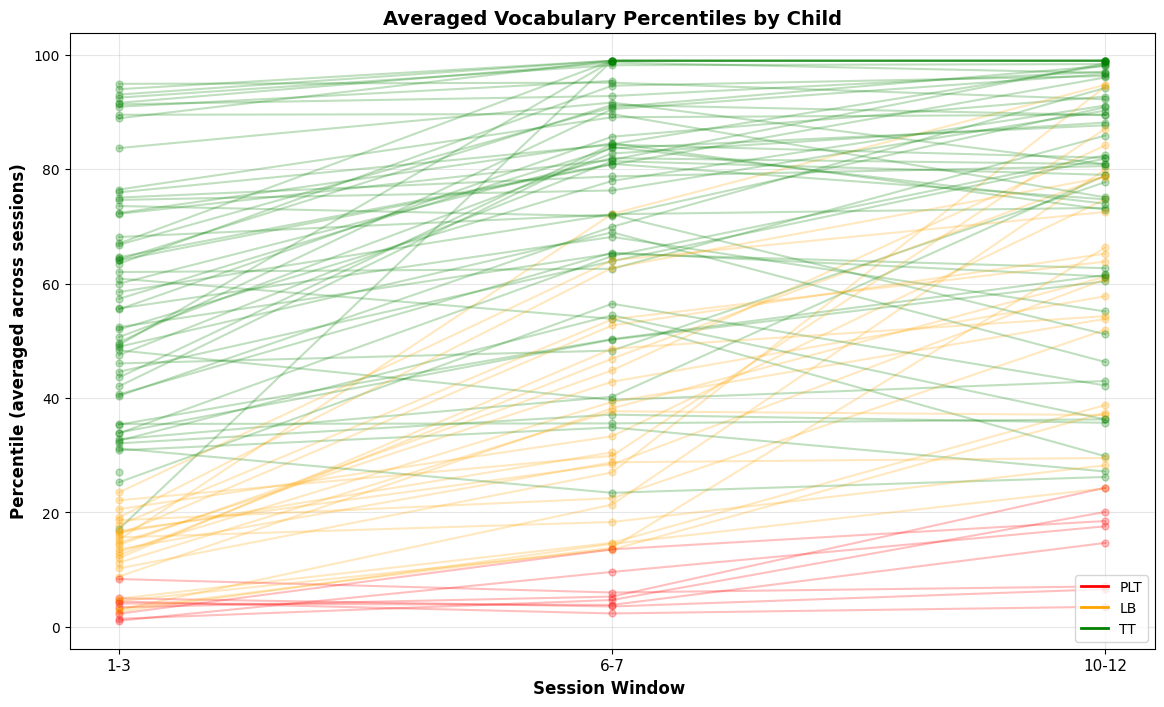

In [19]:
# Line graph per child: averaged percentiles across session windows
import matplotlib.pyplot as plt
import numpy as np

color_map = {'PLT': 'red', 'LB': 'orange', 'TT': 'green', 'Faller': 'red'}

session_windows = [('1-3', 1, 3), ('6-7', 6, 7), ('10-12', 10, 12)]
x_positions = np.arange(1, len(session_windows) + 1)
x_labels = [w[0] for w in session_windows]

fig, ax = plt.subplots(figsize=(14, 8))

for child_id, group in CDI.groupby('child_id'):
    group = group.sort_values('session_num')
    talker_type = group['Talker_Type'].iloc[0]
    if pd.isna(talker_type) or talker_type == 'Faller':
        continue
    color = color_map.get(talker_type, 'gray')
    
    means = []
    for _, start_s, end_s in session_windows:
        vals = group.loc[group['session_num'].between(start_s, end_s), 'percentile'].replace(0, np.nan)
        means.append(vals.mean())
    
    if np.all(np.isnan(means)):
        continue
    
    ax.plot(x_positions, means, color=color, alpha=0.25, linewidth=1.5, marker='o', markersize=5)

ax.set_xticks(x_positions)
ax.set_xticklabels(x_labels, fontsize=11)
ax.set_xlabel('Session Window ', fontsize=12, fontweight='bold')
ax.set_ylabel('Percentile (averaged across sessions)', fontsize=12, fontweight='bold')
ax.set_title('Averaged Vocabulary Percentiles by Child', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Legend
from matplotlib.lines import Line2D
legend_handles = [
    Line2D([0], [0], color=color_map['PLT'], lw=2, label='PLT'),
    Line2D([0], [0], color=color_map['LB'], lw=2, label='LB'),

    Line2D([0], [0], color=color_map['TT'], lw=2, label='TT'),
]
ax.legend(handles=legend_handles, loc='lower right', fontsize=10)